In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "nsl_kdd"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [145]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from collections import Counter

import time
from data_utils import *
import umap
from sklearn.metrics import confusion_matrix


from data_utils import load_train_test_data
from src.feature_extraction import CategoricalExtractor

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

# Utils

In [87]:
def plot_history(network_history, title, ymax=None):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    if ymax is not None:
        plt.ylim(0, ymax)
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
def run_and_measure(fun, *args, **kwargs):
    start = time.time()
    retval = fun(*args, **kwargs)
    end = time.time()
    return retval, end - start
    
    
def train_models(create_model, X_train, Y_train, X_val, Y_val, name, batch_size=8192, n_epochs=50, train=True, lr_start = 0.001, lr_patience = None, verbose = 0):
    histories = []
    models = []
    
    model = create_model(lr=lr_start)
    
    models.append(model)
    
    
    
    if train:
        callbacks = []
        if lr_patience is not None:
            callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=lr_patience, min_delta=0.00005))
            callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=lr_patience*3, restore_best_weights=True, verbose=1))
            
        history, t = run_and_measure(model.fit,
                                    X_train, 
                                    Y_train, 
                                    batch_size = batch_size, 
                                    epochs = n_epochs, 
                                    verbose = verbose,
                                    callbacks = callbacks,
                                    validation_data=(X_val, Y_val))
        histories.append(history)
    
        print(f"{t:0.2f} s")
        
    return histories, models

def plot_histories(histories, title, ymax=1, print_mse=True):
    plt.figure(figsize=(12, 8))
    
    for history in histories:
        plot_history(history,"aaa", ymax)
            

# Preparing data

In [31]:
(X_train, X_test, Y_train, Y_test), attack_classes = load_train_test_data(pwd=pwd, return_classes=True, standardize=True, norm=False, include_categorical=True)

In [32]:
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])
nsl_lables = np.argmax(Y[:], axis=1)

In [33]:
extractor = CategoricalExtractor(8, root=pwd)

In [34]:
extracted_features = extractor.extract_features(X)

2022-06-05 17:51:37.796743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [39]:
extracted_features.shape

(148517, 8)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(extracted_features, Y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = Y)

In [36]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify = Y_train)

In [42]:
np.sum(Y_test, axis=0)

array([10678,  2815,   776,    24, 15411])

In [43]:
attack_classes

array(['DoS', 'Probe', 'R2L', 'U2R', 'normal'], dtype='<U6')

In [82]:
def model_v1(lr = 0.001):
    model = Sequential()
    model.add(Dense(500, activation='relu', input_dim=8))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [83]:
# history = model.fit(X_train, Y_train, batch_size=8000, epochs=500, verbose=1, validation_data=(X_val, Y_val))

In [90]:
histories_v1, models_v1 = train_models(model_v1, X_train, Y_train, X_val, Y_val, "model v1", batch_size=8192, n_epochs=500, train=True, lr_start=0.001, lr_patience=10, verbose=1)

Epoch 1/500
 4/12 [=========>....................] - ETA: 0s - loss: 1.5049 - accuracy: 0.6587

2022-06-05 18:39:17.301838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 31ms/step - loss: 1.2573 - accuracy: 0.7804 - val_loss: 0.8309 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 2/500
 9/12 [=====================>........] - ETA: 0s - loss: 0.6409 - accuracy: 0.8581

2022-06-05 18:39:17.700363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 16ms/step - loss: 0.6059 - accuracy: 0.8575 - val_loss: 0.4464 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 3/500
12/12 [==============================] - 0s 15ms/step - loss: 0.3987 - accuracy: 0.8787 - val_loss: 0.3443 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 4/500
12/12 [==============================] - 0s 15ms/step - loss: 0.3190 - accuracy: 0.9022 - val_loss: 0.2905 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 5/500
12/12 [==============================] - 0s 15ms/step - loss: 0.2756 - accuracy: 0.9178 - val_loss: 0.2579 - val_accuracy: 0.9299 - lr: 0.0010
Epoch 6/500
12/12 [==============================] - 0s 15ms/step - loss: 0.2447 - accuracy: 0.9334 - val_loss: 0.2342 - val_accuracy: 0.9352 - lr: 0.0010
Epoch 7/500
12/12 [==============================] - 0s 15ms/step - loss: 0.2219 - accuracy: 0.9369 - val_loss: 0.2136 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 8/500
12/12 [==============================] - 0s 15ms/step - loss: 0.2049 -

Epoch 55/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0538 - accuracy: 0.9835 - val_loss: 0.0679 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 56/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0526 - accuracy: 0.9837 - val_loss: 0.0642 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 57/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0511 - accuracy: 0.9843 - val_loss: 0.0628 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 58/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0503 - accuracy: 0.9849 - val_loss: 0.0627 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 59/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0503 - accuracy: 0.9844 - val_loss: 0.0623 - val_accuracy: 0.9822 - lr: 0.0010
Epoch 60/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.0625 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 61/500
12/12 [==============================] - 0s 15ms/st

12/12 [==============================] - 0s 15ms/step - loss: 0.0380 - accuracy: 0.9877 - val_loss: 0.0528 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 108/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0377 - accuracy: 0.9881 - val_loss: 0.0507 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 109/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0373 - accuracy: 0.9884 - val_loss: 0.0510 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 110/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0378 - accuracy: 0.9878 - val_loss: 0.0522 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 111/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0378 - accuracy: 0.9878 - val_loss: 0.0528 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 112/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0374 - accuracy: 0.9879 - val_loss: 0.0508 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 113/500
12/12 [==============================] - 0s 15ms/step - lo

12/12 [==============================] - 0s 15ms/step - loss: 0.0324 - accuracy: 0.9892 - val_loss: 0.0487 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 160/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.0481 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 161/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.0490 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 162/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0326 - accuracy: 0.9886 - val_loss: 0.0475 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 163/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0311 - accuracy: 0.9896 - val_loss: 0.0493 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 164/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0315 - accuracy: 0.9898 - val_loss: 0.0492 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 165/500
12/12 [==============================] - 0s 14ms/step - lo

12/12 [==============================] - 0s 15ms/step - loss: 0.0304 - accuracy: 0.9898 - val_loss: 0.0475 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 212/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0281 - accuracy: 0.9908 - val_loss: 0.0472 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 213/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0287 - accuracy: 0.9907 - val_loss: 0.0466 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 214/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0276 - accuracy: 0.9909 - val_loss: 0.0461 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 215/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.0480 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 216/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0276 - accuracy: 0.9907 - val_loss: 0.0469 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 217/500
12/12 [==============================] - 0s 14ms/step - lo

12/12 [==============================] - 0s 16ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0453 - val_accuracy: 0.9887 - lr: 2.5000e-04
Epoch 263/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.0448 - val_accuracy: 0.9891 - lr: 2.5000e-04
Epoch 264/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.0449 - val_accuracy: 0.9898 - lr: 2.5000e-04
Epoch 265/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.0446 - val_accuracy: 0.9895 - lr: 2.5000e-04
Epoch 266/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0452 - val_accuracy: 0.9898 - lr: 2.5000e-04
Epoch 267/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0242 - accuracy: 0.9921 - val_loss: 0.0448 - val_accuracy: 0.9893 - lr: 2.5000e-04
Epoch 268/500
12/12 [===========================

55.74 s


<Figure size 864x576 with 0 Axes>

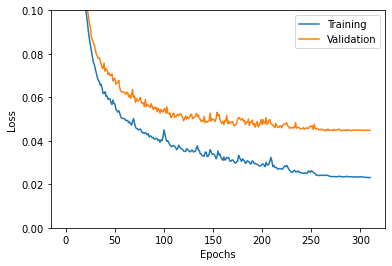

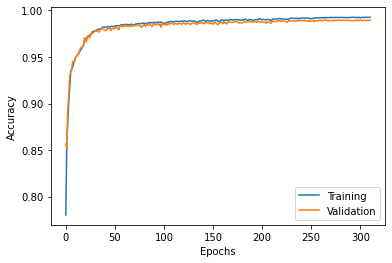

In [91]:
plot_histories(histories_v1, "model v1", 0.1)

In [93]:
Y_test.shape

(29704, 5)

In [94]:
Y_train.shape

(95050, 5)

In [95]:
predictions = model.predict(X_test)

2022-06-05 18:41:42.588351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(33.0, 0.5, 'True')

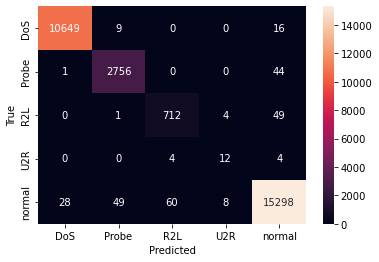

In [133]:
sns.heatmap(confusion_matrix(np.argmax(predictions, axis=1), np.argmax(Y_test, axis=1)), annot=True, fmt="d", xticklabels=attack_classes, yticklabels=attack_classes)
plt.xlabel("Predicted")
plt.ylabel("True")

In [134]:
(_, _, Y_train, Y_test), attack_classes = load_train_test_data(pwd=pwd, return_classes=True, standardize=True, norm=False, 
                                                               include_categorical=True, group_y=False)

In [150]:
data_labels_train = np.argmax(Y_train, axis=1)

In [151]:
data_labels_train

array([16, 16, 14, ..., 16, 14, 16])

In [154]:
data_classes_train = np.array([attack_classes[y] for y in data_labels_train])

In [155]:
data_classes_train

array(['normal', 'normal', 'neptune', ..., 'normal', 'neptune', 'normal'],
      dtype='<U15')

In [156]:
print(Counter(data_classes_train))

Counter({'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2})


In [162]:
data_labels_test = np.argmax(Y_test, axis=1)

In [163]:
data_labels_test

array([14, 14, 16, ...,  1, 16, 11])

In [164]:
data_classes_test = np.array([attack_classes[y] for y in data_labels_test])

In [165]:
data_classes_test

array(['neptune', 'neptune', 'normal', ..., 'back', 'normal', 'mscan'],
      dtype='<U15')

In [166]:
print(Counter(data_classes_test))

Counter({'normal': 9711, 'neptune': 4657, 'guess_passwd': 1231, 'mscan': 996, 'warezmaster': 944, 'apache2': 737, 'satan': 735, 'processtable': 685, 'smurf': 665, 'back': 359, 'snmpguess': 331, 'saint': 319, 'mailbomb': 293, 'snmpgetattack': 178, 'portsweep': 157, 'ipsweep': 141, 'httptunnel': 133, 'nmap': 73, 'pod': 41, 'buffer_overflow': 20, 'multihop': 18, 'named': 17, 'ps': 15, 'sendmail': 14, 'xterm': 13, 'rootkit': 13, 'teardrop': 12, 'xlock': 9, 'land': 7, 'xsnoop': 4, 'ftp_write': 3, 'loadmodule': 2, 'worm': 2, 'perl': 2, 'sqlattack': 2, 'udpstorm': 2, 'phf': 2, 'imap': 1})
